### Training for Linear Probing

1. Get the indices of data points in train/valid/test sets by parsing BED file.

2. Load the HDF5 files of embeddings and labels through a custom Dataset.

3. Train and evaluate the model on log Poisson loss and Pearson coefficient.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from linear_transform import LinearTransform
from pearsonr import PearsonR
from utils import *

%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using {device} device")

Using mps device


In [3]:
probe = LinearTransform()
probe.to(device)

LinearTransform(
  (conv_layer): Conv1d(1536, 18, kernel_size=(1,), stride=(1,))
  (activation): Softplus(beta=1, threshold=20)
)

In [4]:
epochs = 10
learning_rate = 0.15
optimizer = torch.optim.SGD(probe.parameters(), lr=learning_rate, momentum=0.99)
criterion = nn.PoissonNLLLoss(log_input=False)
pearson = PearsonR(num_targets=18)

In [5]:
epoch_loss, epoch_coeff = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")

    loss, num_batches = 0, 0
    for i in range(341):  # Go through all 341 chunks of train data!
        train_embeds = f'./data/embeds/train_chunk_X{i+1}.h5'
        train_labels = f'./data/labels/train_chunk_y{i+1}.h5'
        train_data = H5Dataset(train_embeds, train_labels)
        train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
        train_tuple = train_loop(train_loader, probe, device, criterion, optimizer, pearson)
        loss += train_tuple[0]  # First element of the tuple is the loss.
        num_batches += train_tuple[1]  # Second element of the tuple is num_batches of chunk.
    train_loss = loss / num_batches
    train_coeff = pearson.result()
    pearson.reset_state()
    print(f"Training loss: {train_loss}, Training coefficient: {train_coeff}")

    loss, num_batches = 0, 0
    for j in range(23):  # Go through all 23 chunks of validation data!
        valid_embeds = f'./data/embeds/valid_chunk_X{j+1}.h5'
        valid_labels = f'./data/labels/valid_chunk_y{j+1}.h5'
        valid_data = H5Dataset(valid_embeds, valid_labels)
        valid_loader = DataLoader(valid_data, batch_size=4, shuffle=True)
        valid_tuple = validation_test_loop(valid_loader, probe, device, criterion, pearson)
        loss += valid_tuple[0]
        num_batches += valid_tuple[1]
    valid_loss = loss / num_batches
    valid_coeff = pearson.result()
    pearson.reset_state()
    print(f"Validation loss: {valid_loss}, Validation coefficient: {valid_coeff}\n")

    epoch_loss.append((train_loss, valid_loss))
    epoch_coeff.append((train_coeff, valid_coeff))

print("Done!")

Epoch 1
-------------------------------
Training loss: -407.12747002993365, Training coefficient: 0.22145049273967743
Validation loss: -436.5373394136394, Validation coefficient: 0.5450776219367981

Epoch 2
-------------------------------
Training loss: -413.4211959533907, Training coefficient: 0.5264798998832703
Validation loss: -436.49618574342145, Validation coefficient: 0.5422861576080322

Epoch 3
-------------------------------
Training loss: -413.37592885949994, Training coefficient: 0.5384381413459778
Validation loss: -436.04355249508194, Validation coefficient: 0.5511985421180725

Epoch 4
-------------------------------
Training loss: -413.44537757498614, Training coefficient: 0.5446035861968994
Validation loss: -436.0543973075784, Validation coefficient: 0.5559177398681641

Epoch 5
-------------------------------
Training loss: -413.4639394810809, Training coefficient: 0.5424681305885315
Validation loss: -436.106861321074, Validation coefficient: 0.5487861037254333

Epoch 6
--

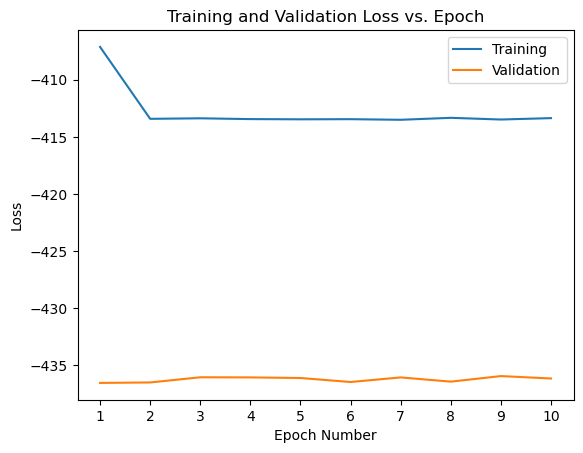

In [6]:
plot_loss(epoch_loss)

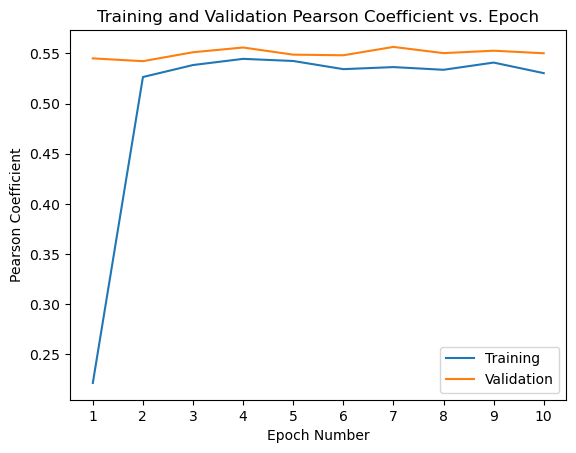

In [7]:
plot_coefficient(epoch_coeff)

In [8]:
torch.save(probe.state_dict(), 'first_full_run.pth')